# Image Classification and Transfer Learning

This notebook is mostly a cut and paste of:

1. [Keras Image Classiciation Example](https://keras.io/examples/vision/image_classification_from_scratch/)
1. [Keras Transfer Learning Example](https://keras.io/examples/vision/keypoint_detection/)
1. [Keras Transfer Learning Documentation](https://keras.io/guides/transfer_learning/)

## Plan

The plan for today is to setup a image classification scenario where there are insufficient examples in the training set, necessitating the use of Transfer Learning.

## Image Classification Example

This section is basically a cut and paste of the [Keras Image Classiciation Example](https://keras.io/examples/vision/image_classification_from_scratch/), so I won't copy and paste the text also. We will follow the example from the Keras page.

Differences are:
* To "simulate" the cirmumstance of small training sample, we'll delete all but 1000 images of each class.
* We will only train a few epochs to demonstrate it's not doing well.
* We use a slightly larger image size (for compatibility with more models for transfer learning).


In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


2024-08-01 09:51:27.122897: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 09:51:27.318969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 09:51:28.623518: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 09:51:28.629118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 09:51:30.813441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

We are downloading the data here. Note that it's commented out because we only need to do this once.

In [2]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

We also only need to unzip once.

In [2]:
#!unzip -q kagglecatsanddogs_5340.zip
!ls

'Image Classification and Transfer Learning.ipynb'		     Jelly_Fish
'Image Classification and Transfer Learning.ipynb:Zone.Identifier'


In [3]:
!ls Jelly_Fish

Moon_jellyfish	  blue_jellyfish	mauve_stinger_jellyfish
Train_Test_Valid  compass_jellyfish
barrel_jellyfish  lions_mane_jellyfish


And we only need to delete the extra images only once.

num_skipped = 0
for folder_name in ("Moon_jellyfish"):
    max_images = 100
    folder_path = os.path.join("Jelly_Fish", folder_name)
    for image_i,fname in enumerate(os.listdir(folder_path)):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if image_i > max_images or not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
             
print(f"Deleted {num_skipped} images.")

Note the image size change:

In [25]:
#image_size = (180, 180)
image_size = (224, 224)

batch_size = 10

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "Jelly_Fish",
    validation_split=0.2,
    label_mode="categorical",
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 900 files belonging to 6 classes.
Using 720 files for training.
Using 180 files for validation.


TypeError: only size-1 arrays can be converted to Python scalars

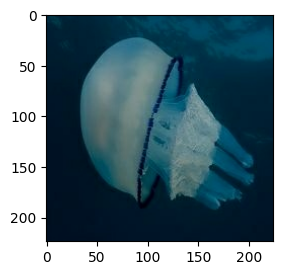

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [27]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

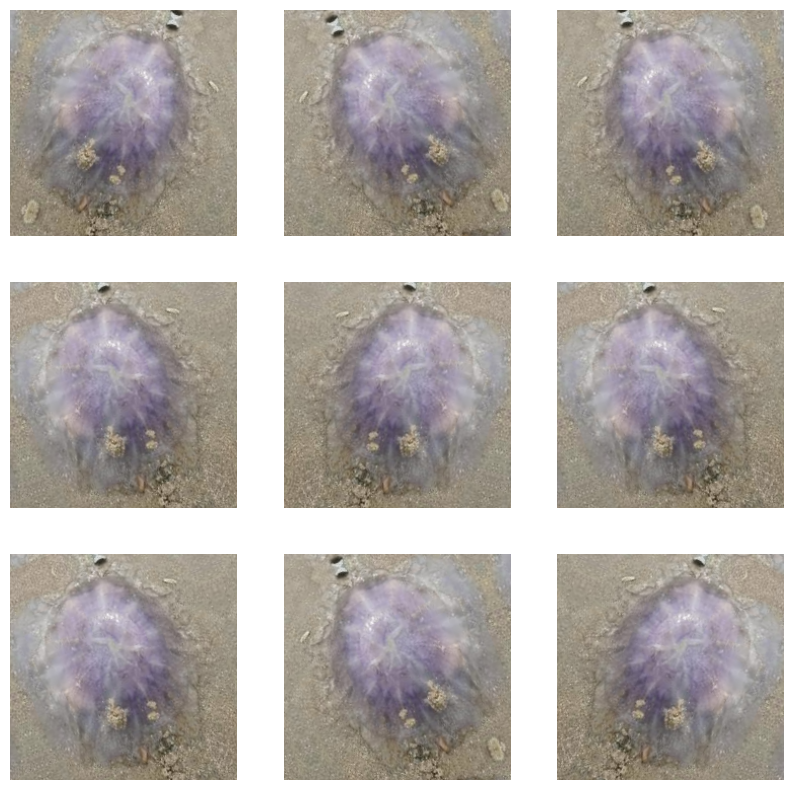

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [28]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [29]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=6)
#keras.utils.plot_model(model, show_shapes=True)

In [30]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
72/72 [==============================] - ETA: 0s - loss: 1.6681 - acc: 0.3236

2024-08-02 13:12:57.138086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model_2/add_8/add' exist for missing node 'model_2/add_7/add'.
2024-08-02 13:12:57.173323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model_2/add_8/add' exist for missing node 'model_2/add_7/add'.


72/72 [==============================] - 89s 1s/step - loss: 1.6681 - acc: 0.3236 - val_loss: 1.7907 - val_acc: 0.1444
Epoch 2/8
72/72 [==============================] - 95s 1s/step - loss: 1.5400 - acc: 0.3944 - val_loss: 1.7912 - val_acc: 0.1444
Epoch 3/8
72/72 [==============================] - 98s 1s/step - loss: 1.3246 - acc: 0.4792 - val_loss: 1.7945 - val_acc: 0.1444
Epoch 4/8
72/72 [==============================] - 99s 1s/step - loss: 1.2749 - acc: 0.5097 - val_loss: 1.7981 - val_acc: 0.1444
Epoch 5/8
72/72 [==============================] - 100s 1s/step - loss: 1.2588 - acc: 0.5125 - val_loss: 1.7962 - val_acc: 0.1444
Epoch 6/8
72/72 [==============================] - 101s 1s/step - loss: 1.0835 - acc: 0.5917 - val_loss: 1.7863 - val_acc: 0.1333
Epoch 7/8
72/72 [==============================] - 101s 1s/step - loss: 1.0704 - acc: 0.6125 - val_loss: 1.7592 - val_acc: 0.2500
Epoch 8/8
72/72 [==============================] - 100s 1s/step - loss: 0.9757 - acc: 0.6208 - val_loss:

As you can see, the model doesn't perform very well on this small dataset. It also takes a very long time to go through the data on this laptop without a GPU.

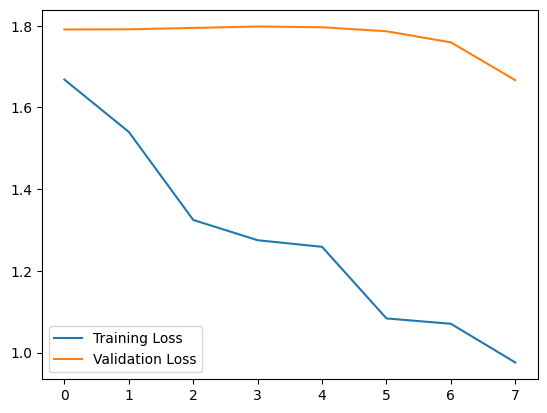

In [31]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

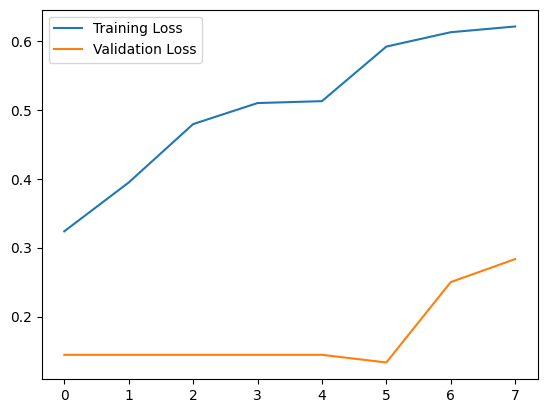

In [32]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

## Transfer Learning

Now we will follow [Keras Transfer Learning Example](https://keras.io/examples/vision/keypoint_detection/), which is setup for a different task (object detection).

Differences from that example:
* Using the same cat/dog dataset as before.
* Changing task from object detection to classification, using exactly the same final layers as the model above.
* Wrapping things in functions that mirror what we did above.

In [33]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [36]:
model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=6)

In [37]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model2.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
72/72 [==============================] - 10s 107ms/step - loss: 1.7307 - acc: 0.3375 - val_loss: 1.2968 - val_acc: 0.5556
Epoch 2/8
72/72 [==============================] - 8s 107ms/step - loss: 1.1755 - acc: 0.5944 - val_loss: 0.9927 - val_acc: 0.6889
Epoch 3/8
72/72 [==============================] - 8s 110ms/step - loss: 0.9174 - acc: 0.6750 - val_loss: 0.8047 - val_acc: 0.7278
Epoch 4/8
72/72 [==============================] - 8s 113ms/step - loss: 0.7550 - acc: 0.7556 - val_loss: 0.6953 - val_acc: 0.7722
Epoch 5/8
72/72 [==============================] - 8s 113ms/step - loss: 0.6186 - acc: 0.8125 - val_loss: 0.6221 - val_acc: 0.8000
Epoch 6/8
72/72 [==============================] - 8s 109ms/step - loss: 0.5866 - acc: 0.8069 - val_loss: 0.5604 - val_acc: 0.8278
Epoch 7/8
72/72 [==============================] - 8s 115ms/step - loss: 0.4998 - acc: 0.8542 - val_loss: 0.5145 - val_acc: 0.8389
Epoch 8/8
72/72 [==============================] - 8s 109ms/step - loss: 0.4498 - 

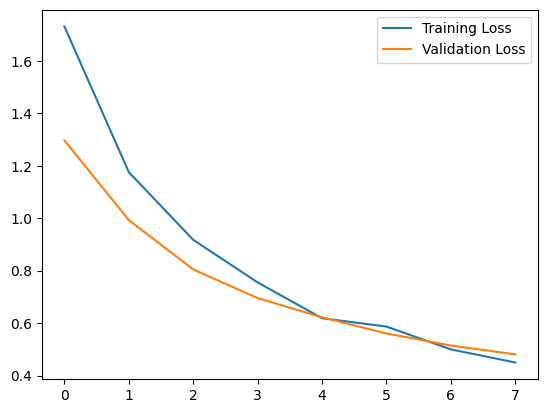

In [38]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

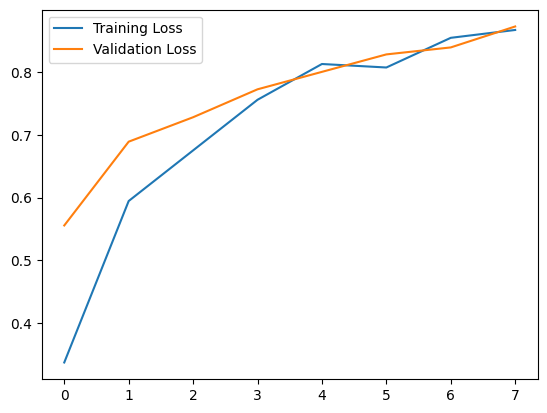

In [39]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

## Computer Vision Homework

* Select an image classification dataset of your choice. 
    * Images should be at least 100x100 size.
    * Image datasets are can be very large and we are going to only use a relatively subset.
        * Select Datasets that are either:
            * Reasonable size 
                * You can download in reasonable time 
                * Small enough to not take too much space on your computer
            * Allow you to download a subset.
    * Some example datasets:
        * [Big list from Kaggle](https://www.kaggle.com/datasets?search=image)
        * [Images of buildings, forest, glacier, mountain, sea, street](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
        * [Indoor Scenes](https://www.kaggle.com/datasets/itsahmad/indoor-scenes-cvpr-2019/data)
        * [Concrete Cracks](https://data.mendeley.com/datasets/5y9wdsg2zt/2)
        * [Architectural Elements](https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset)
        * [Fruits](https://www.kaggle.com/datasets/moltean/fruits)
        * [Scene Understanding](https://www.tensorflow.org/datasets/catalog/sun397)
        * [blood-cells](https://www.kaggle.com/datasets/paultimothymooney/blood-cells)
        * [Cellular Recursion](https://www.kaggle.com/datasets/xhlulu/recursion-cellular-image-classification-224-jpg)
* Create a new notebook for working out the data loader and augmentation (`DataLoader.ipynb`).
    * Follow the Keras examples and this notebook.
    * Setup the dataset for a demonstration of transfer learning
        * Perform any cleaning necessary, like throwing out bad images. 
            * This will be specific to your dataset. 
            * You may discover a problem later, come back and eliminate the bad images here.
        * Select at most 5 classes. Discard the rest of the data.
        * Create a smaller subset of less 100 images per class for training and testing.
        * Figure out how the labels are provided and create a data loader to load the data.
            * If the images are separated into subdirectories, the example above works.
            * If the image information is in a CSV file, easist path is to figure out the way to separate your classes into subdirectories and use the above example.
    * Visualize the images, making sure the data loader is working properly.
    * Create a module which holds the data loader and any other code you may need to reuse.
* Create a new notebook to train a baseline model (`TrainBaseModel.ipynb`)
    * Implement and train a transfer learning model, selecting a model from [Keras Built-in Vision Models](https://keras.io/api/applications/)
    * Make sure you look make the learning curves.
    * Save the model using `model.save()` (see [Keras Model Saving](https://keras.io/guides/serialization_and_saving/)
* Create a new notebook to see effect of data augmentation a baseline model (`TrainBaseModelAugmentation.ipynb`):
    * Add data augmentation.
        * Select at least 3 augmentations that make sense for your datasets (see [Keras Image Augmentation Layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)).
        * Visualize the data augmentation to make sure it's working as expected.
    * Train the same model now with data augmentation.
    * Save the new model.   
    * Test if data augmentation is helping:
        * Create a new notebook (`CompareAugmentation.ipynb`)
        * Load the 2 models and compare the ROC curves with and without augmentation.
* Train the three different transfer learning models (`Train-XXXX.ipynb`):
    * Select 2 additional models from [Keras Built-in Vision Models](https://keras.io/api/applications/).
    * Create a new notebook for the each model.
        * Implement and train the model.
        * Make sure you look make the learning curves.
        * Save the model using `model.save` (see [Keras Model Saving](https://keras.io/guides/serialization_and_saving/)
    * Copy the notebook and try a different base model.
* Compare the three models:
    * Create a new notebook (`CompareModels.ipynb`)
    * Load the 3 models.
    * Make a plot comparing the 3 ROC curves of the 3 models on the validation dataset.
